# Testing the initial conditions for consistency
I will be assuming that the ions are uniformly distributed with a charge of +1.

## Load data

In [48]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("case1-input.txt", sep="\s+")
data.columns = ["radius", "number_density", "azimuthal_velocity", "temperature", "radial_electric_field"]
data.head()

,radius,number_density,azimuthal_velocity,temperature,radial_electric_field
0,0.000000,0.213281,0.000000e+00,0.000001,0.000000
1,0.000005,0.213299,-4.499460e-10,0.000001,0.000002
2,0.000010,0.213353,-3.598273e-09,0.000001,0.000004
3,0.000015,0.213444,-1.213689e-08,0.000001,0.000006
4,0.000020,0.213571,-2.874479e-08,0.000001,0.000008


## Gauss' Law
Check that E = div(rho), where rho is the charge density. Note that we are assuming an underlying uniform distribution of ions.

In [3]:
qe = -1 # electron charge
qi = 1 # ion charge
ni = 1 # ion density
rho = data.number_density * qe + ni * qi
div_E = (data.radial_electric_field * data.radius).diff() / (data.radius.diff() * data.radius)

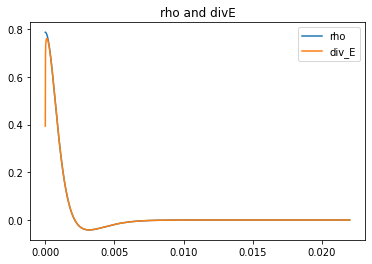

In [22]:
plt.plot(data.radius[1:], rho[1:])
plt.plot(data.radius[1:], div_E[1:])
plt.legend(["rho", "div_E"])
plt.title("rho and divE")
plt.show()

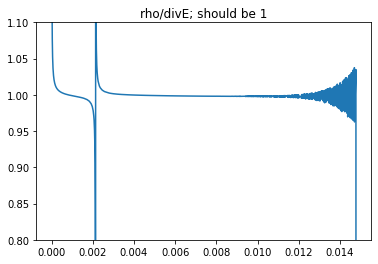

In [20]:
start=1
end=-1
plt.plot(data.radius[start:end], rho[start:end] / div_E[start:end])
plt.ylim(.8,1.1)
plt.title("rho/divE; should be 1")
plt.show()

It seems that the uniform ion distribution was correct. However, E has some issues for small and large radii. This probably explains the discrepancy at small radii between psc's calculated E and the initial E from file. Note that E=0 when radius>.015:

In [18]:
box_half_size = .015
div_E[data.radius > box_half_size]

3001    0.0
3002    0.0
3003    0.0
3004    0.0
3005    0.0
       ... 
4396    0.0
4397    0.0
4398    0.0
4399    0.0
4400    0.0
Length: 1400, dtype: float64

## No Net Charge
Periodic boundary conditions require that the net charge is 0. I will do this in two different ways: once by directly integrating charge density over the *square* region, and also by computing the surface integral of E•dA over the square region.

Actually, the latter method has effectively been done. We've seen that E=0 when r>.015, so the surface integral is 0 as it should be.

In [64]:
# naive integral over entire circle of (rho r dr dtheta), where integral over theta is 2pi
(rho * data.radius * 2*np.pi * data.radius.diff()).sum()

-8.790741732309676e-12

arclen contains nan: False


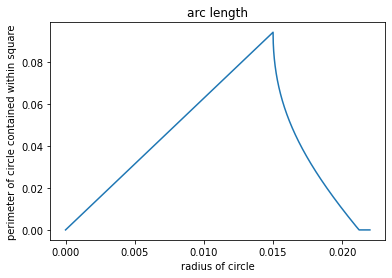

In [89]:
arclen = data.radius * 8 * (np.pi/4 - np.arccos(np.minimum(1, .015/data.radius)))
arclen[data.radius > box_half_size * 2**.5] = 0

print(f"arclen contains nan: {arclen.isnull().values.any()}")

plt.plot(data.radius, arclen)
plt.title("arc length")
plt.ylabel("perimeter of circle contained within square")
plt.xlabel("radius of circle")
plt.show()

In [100]:
# integral over square of (rho r dr dtheta), where integral over theta is arclen
net_charge = (rho * data.radius * arclen * data.radius.diff()).sum()
net_charge

-1.0038567465478331e-08

So the total charge in the square region is about -1e-8. The total charge would be a thousand times smaller (-9e-12) if we calculate it for the circular region detailed in the input file. I don't particularly like that fact, but maybe 1e-8 is small enough.

# Conclusions
The discrepancy in E for small radius is enough that I want to recalculate E for the initial conditions instead of using the given E. I also might consider slightly increasing the ion density or charge to bring the net charge closer to 0. I could do this by using the following value for `ni`:

In [102]:
ni -= net_charge / (2*box_half_size) ** 2
ni

1.000022307927701

# Appendix
Here are some other plots that are nice.

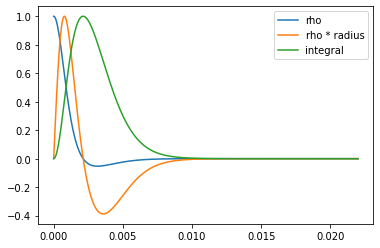

In [99]:
rho_r = rho * data.radius
int_rho_r = (rho_r * data.radius.diff()).cumsum()

max1 = rho.abs().max()
max2 = rho_r.abs().max()
max3 = int_rho_r.abs().max()

# scale everything
plt.plot(data.radius, rho / max1)
plt.plot(data.radius, rho * data.radius / max2)
plt.plot(data.radius, (rho * data.radius * data.radius.diff()).cumsum() / max3)
plt.legend(["rho", "rho * radius", "integral"])
plt.show()